<a href="https://colab.research.google.com/github/VellummyilumVinoth/-Fine-Tuning-BERT-with-Masked-Language-Modeling/blob/main/Fine_Tuning_BERT_with_Masked_Language_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install transformers

! pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 40.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 60.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 17.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 19.2 MB/s eta 0:00:00


In [2]:
from transformers import BertTokenizer, TFBertForMaskedLM
import tensorflow as tf
import os
import numpy as np
import re
import matplotlib.pyplot as plt

In [3]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = TFBertForMaskedLM.from_pretrained('bert-base-uncased')

All model checkpoint layers were used when initializing TFBertForMaskedLM.

All the layers of TFBertForMaskedLM were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForMaskedLM for predictions without further training.


In [4]:
model.summary()

Model: "tf_bert_for_masked_lm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108891648 
                                                                 
 mlm___cls (TFBertMLMHead)   multiple                  24459834  
                                                                 
Total params: 109,514,298
Trainable params: 109,514,298
Non-trainable params: 0
_________________________________________________________________


In [5]:
with open('The Hunger Games.txt','r') as f:
    file = f.read().split(".")

def clean_text(line):
    line = re.sub(r'-+',' ',line)
    line = re.sub(r'[^a-zA-Z, ]+'," ",line)
    line = re.sub(r'[ ]+'," ",line)
    line += "."
    return line

text_lst = []
len_lst = []
for line in file:
    if len(line.split(" ")) >=20:
        line = clean_text(line)
        text_lst.append(line)
        len_lst.append(len(line.split(" ")))


In [6]:
text_lst

[' Even though it was years ago, I think he still remembers how I tried to drown him in a bucket when Prim brought him home.',
 ' I pull on trousers, a shirt, tuck my long dark braid up into a cap, and grab my forage bag.',
 ' On the table, under a wooden bowl to protect it from hungry rats and cats alike, sits a perfect little goat cheese wrapped in basil leaves.',
 ' Our part of District , nicknamed the Seam, is usually crawling with coal miners heading out to the morning shift at this hour.',
 ' Men and women with hunched shoulders, swollen knuckles, many who have long since stopped trying to scrub the coal dust out of their broken nails, the lines of their sunken faces.',
 ' Separating the Meadow from the woods, in fact enclosing all of District , is a high chain link fence topped with barbed wire loops.',
 ' In theory, its supposed to be electrified twenty four hours a day as a deterrent to the predators that live in the woods packs of wild dogs, lone cougars, bears that used to t

In [7]:
inputs = tokenizer(text_lst,max_length=100,truncation=True,padding='max_length',return_tensors='tf')

print(inputs.keys())

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])


In [8]:
inputs['labels'] = inputs['input_ids']
inputs.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'labels'])

In [9]:
inp_ids = []
lbs = []
idx = 0
for inp in inputs.input_ids.numpy():
    actual_tokens = list(set(range(100)) - 
                         set(np.where((inp == 101) | (inp == 102) 
                            | (inp == 0))[0].tolist()))
    #We need to select 15% random tokens from the given list
    num_of_token_to_mask = int(len(actual_tokens)*0.15)
    token_to_mask = np.random.choice(np.array(actual_tokens), 
                                     size=num_of_token_to_mask, 
                                     replace=False).tolist()
    #Now we have the indices where we need to mask the tokens
    inp[token_to_mask] = 103
    inp_ids.append(inp)
    idx += 1
inp_ids = tf.convert_to_tensor(inp_ids)
inputs['input_ids'] = inp_ids

In [10]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))
history = model.fit([inputs.input_ids,inputs.attention_mask],inputs.labels,verbose=1,batch_size=8,epochs=10)

Epoch 1/10
196/196 [==============================] - 90s 212ms/step - loss: 0.4966
Epoch 2/10
196/196 [==============================] - 43s 219ms/step - loss: 0.0557
Epoch 3/10
196/196 [==============================] - 44s 225ms/step - loss: 0.0201
Epoch 4/10
196/196 [==============================] - 44s 224ms/step - loss: 0.0068
Epoch 5/10
196/196 [==============================] - 44s 225ms/step - loss: 0.0034
Epoch 6/10
196/196 [==============================] - 44s 224ms/step - loss: 0.0020
Epoch 7/10
196/196 [==============================] - 44s 225ms/step - loss: 0.0023
Epoch 8/10
196/196 [==============================] - 44s 224ms/step - loss: 0.0017
Epoch 9/10
196/196 [==============================] - 44s 224ms/step - loss: 0.0016
Epoch 10/10
196/196 [==============================] - 44s 225ms/step - loss: 0.0016


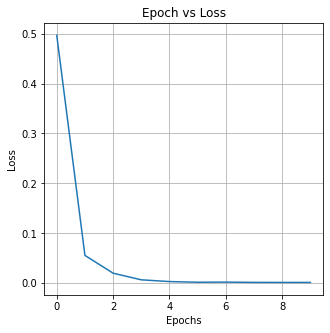

In [11]:
losses = history.history['loss']
fig = plt.figure(figsize=(5,5))
ax1 = fig.add_subplot(111)
ax1.plot(range(len(losses)),losses)
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.set_title("Epoch vs Loss")
plt.grid()
plt.show()

In [12]:
query = "Good morning [MASK], have a [MASK] day"
inp = tokenizer(query,return_tensors='tf')
mask_loc = np.where(inp.input_ids.numpy()[0] == 103)[0].tolist()
out = model(inp).logits[0].numpy()
predicted_tokens = np.argmax(out[mask_loc],axis=1).tolist()
tokenizer.decode(predicted_tokens)
#outputs

'everybody good'